# Compiling Unitaries Using Diffusion Models

This tutorial is based on the work presented in

> ["Synthesis of discrete-continuous quantum circuits with multimodal diffusion models", Florian Fürrutter, Zohim Chandani, Ikko Hamamura, Hans J. Briegel & Gorka Muñoz-Gil, arXiv.2506.01666 (2025)](https://doi.org/10.48550/arXiv.2506.01666)

and
> ["Quantum circuit synthesis with diffusion models", Florian Fürrutter, Gorka Muñoz-Gil & Hans J. Briegel , Nat. Mach. Intell. **6**, 515–524 (2024)](https://doi.org/10.1038/s42256-024-00831-9). 

Quantum computing relies on efficiently translating quantum operations into viable physical realizations on existing quantum hardware. Recently, diffusion models — a powerful class of generative models in machine learning — have demonstrated exceptional performance on this task. 

In this tutorial notebook, we will demonstrate how to use this method to synthesize arbitrary unitaries into a `cudaq.kernel`, effectively decomposing them into sequences of quantum gates, a process commonly known as unitary compilation.

Our focus will be on generating circuits using a pre-trained diffusion model. Specifically, we will illustrate how to compile different unitaries into discrete quantum gates, based on the methods presented in [(Fürrutter et al., 2024)](https://doi.org/10.1038/s42256-024-00831-9), and continuous quantum gates, based on [(Fürrutter et al., 2025)](https://doi.org/10.48550/arXiv.2506.01666).

### Diffusion model pipeline

Generative diffusion models (DMs) have recently delivered remarkable results across a wide range of applications, from image generation to protein folding. In this work, we leverage DMs to generate quantum circuits based on a user specified unitary matrix and a text prompt that defines the allowed gate set, effectively using DMs as unitary compilers. The method is thoroughly explained in Ref. [(Fürrutter et al., 2024)](https://doi.org/10.1038/s42256-024-00831-9). The following figure  provides an overview of the proposed circuit generation pipeline:

<figure>
  <img src="images/pipeline_simplified.png" alt="Quantum circuit generation pipeline overview" width="70%"/>
  <figcaption><b>Quantum circuit generation pipeline</b>. Figure adapted from <a href="https://doi.org/10.1038/s42256-024-00831-9">(Fürrutter et al., 2024)</a></figcaption>
</figure>

The pipeline consists of 3 main components:

**1) Circuit encoding:** Like any neural network, diffusion models operate with continuous inputs and outputs. However, since the circuits we consider are composed of discrete gates (i.e., with no continuous parameters), we develop a mapping that transforms each gate into a continuous vector. This allows us to represent a given circuit as a three-dimensional tensor, as illustrated. Crucially, this mapping is invertible: when the DM generates continuous tensors, we can apply the inverse map to convert them back into the circuit form. An overview of these steps is provided in the figure below:

<figure>
  <img src="images/circuit_encoding.png" alt="Quantum circuit encoding" width="60%"/>
  <figcaption><b>Quantum circuit encoding</b>. Figure adapted from <a href="https://doi.org/10.1038/s42256-024-00831-9">(Fürrutter et al., 2024)</a></figcaption>
</figure>

**2) Conditioning:** The user's input (the set of available gates and the unitary to compile) is also transformed into a continuous tensor by two neural networks. For the gate set description, where the input is a text prompt (e.g., "Compile using ['x', 'h']"), we utilize a pre-trained language model. For the unitary, we employ a neural network that is trained jointly with the diffusion model.

**3) Unitary compilation:** The generation procedure follows the typical DM process: the model is given a fully noisy tensor which is iteratively de-noised until reaching a clean sample based on the given conditioning (the desired unitary and gate set). The tensors generated by the DM are then mapped to circuits via the inverse encoding procedure. To learn more about the practical implementation of diffusion models we recommend [this tutorial](https://course.fast.ai/Lessons/lesson9.html). 

In the following, we will use `cudaq` and [`genQC`](https://github.com/FlorianFuerrutter/genQC) to perform all these steps and go from a desired unitary matrix $U$ to a quantum circuit that we can execute using CUDA-Q. 

> **Extension to discrete-continuous quantum circuits:**
Recently, in [Fürrutter et al. (2025)](https://doi.org/10.48550/arXiv.2506.01666), the authors introduced the next generation of compilation models, utilizing not only discrete gates but also continuous quantum gates in a multimodal diffusion model. We refer interested readers to the paper for more advanced details on the method. Moreover, we will also cover its use in the sections below.

## Setup and load models

First, we make sure we have a compatible version of `genQC` ([github.com/FlorianFuerrutter/genQC](https://github.com/FlorianFuerrutter/genQC)) installed.

In [1]:
!pip install genQC==0.2.3 -q

In [2]:
import cudaq
import torch
import numpy as np
import genQC

import genQC.utils.misc_utils as util
from genQC.pipeline.diffusion_pipeline import DiffusionPipeline
from genQC.pipeline.multimodal_diffusion_pipeline \
            import MultimodalDiffusionPipeline_ParametrizedCompilation

from genQC.platform.tokenizer.circuits_tokenizer import CircuitTokenizer
from genQC.platform.simulation import Simulator, CircuitBackendType
from genQC.scheduler.scheduler_dpm import DPMScheduler

from genQC.inference.sampling \
            import decode_tensors_to_backend, generate_compilation_tensors
from genQC.inference.evaluation_helper import get_unitaries
from genQC.inference.eval_metrics import UnitaryInfidelityNorm

In [3]:
device = util.infer_torch_device() # Use CUDA if we have a GPU
print(device)

[INFO]: Cuda device has a capability of 8.6 (>= 8), allowing tf32 matmul.
cuda


We set a fixed seed for reproducibility.

In [4]:
# We set a seed to pytorch, numpy and python. 
# Note: This will also set deterministic cuda algorithms, possibly at the cost of reduced performance!
util.set_seed(0)

For evaluation, we also need to specify the `cudaq` circuit simulator backend.

In [5]:
simulator = Simulator(CircuitBackendType.CUDAQ, 
                      target='qpp-cpu')  # Target for cudaq, note that cpu is faster for low qubit kernels

### Load discrete model

First, we load pre-trained model weights for a discrete model directly from [Hugging Face: Floki00/qc_unitary_3qubit](https://huggingface.co/Floki00/qc_unitary_3qubit) and setup the DM pipeline. For details of the model we refer to the paper [Fürrutter et al., 2024](https://doi.org/10.1038/s42256-024-00831-9). Note that this model is only trained on 3 qubit unitaries up to 12 gates.

In [6]:
discrete_pipeline = DiffusionPipeline.from_pretrained(
            repo_id="Floki00/qc_unitary_3qubit", # Download model from Hugging Face
            device=device)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model.pt:   0%|          | 0.00/28.8M [00:00<?, ?B/s]

config.yaml: 0.00B [00:00, ?B/s]

[INFO]: `genQC.models.unet_qc.QC_Compilation_UNet` instantiated from given `config` on cuda.
[INFO]: Loading model from `/home/.cache/huggingface/hub/models--Floki00--qc_unitary_3qubit/snapshots/e12810ea65a9a88832fadd34834894e8174658a5/model.pt` onto device: cuda.
[INFO]: `genQC.models.unet_qc.QC_Compilation_UNet`. Freeze model: True


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

[INFO]: `genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder` instantiated from given `config` on cuda.
[INFO]: `genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder`. Found no key `save_type` in `config`. No state dict loaded.
[INFO]: `genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder`. Freeze model: True


The loaded discrete model is trained with the discrete gate set:

In [7]:
discrete_pipeline.gate_pool

['h', 'cx', 'z', 'x', 'ccx', 'swap']

which we need in order to define the `discrete_vocabulary` and create a `CircuitTokenizer`, allowing us to decode tokenized circuits generated by the model.

In [8]:
discrete_vocabulary = {g:i+1 for i, g in enumerate(discrete_pipeline.gate_pool)} 
discrete_tokenizer  = CircuitTokenizer(discrete_vocabulary)
discrete_tokenizer.vocabulary

{'h': 1, 'cx': 2, 'z': 3, 'x': 4, 'ccx': 5, 'swap': 6}

Set parameters the model was trained on. Note that these are fixed and depend on the pre-trained model.

In [9]:
# These parameters are specific to our pre-trained model.
discrete_system_size   = 3
discrete_max_gates     = 12

**Set inference parameters**

Then, we setup diffusion model inference parameters. These can be changed in principle, as they are sample hyperparameters.

In [10]:
timesteps = 40
discrete_pipeline.scheduler.set_timesteps(timesteps) 

### Load continuous model

Next, we load pre-trained model weights for a discrete-continuous model directly from [Hugging Face: Floki00/cirdit_multimodal_compile_3to5qubit](https://huggingface.co/Floki00/cirdit_multimodal_compile_3to5qubit) and setup the DM pipeline. For details of the model, we refer to the paper [Fürrutter et al., 2025](https://doi.org/10.48550/arXiv.2506.01666). Note that this model is trained on 3 to 5 qubit unitaries up to 32 gates.

In [11]:
cont_pipeline = MultimodalDiffusionPipeline_ParametrizedCompilation.from_pretrained(
    repo_id="Floki00/cirdit_multimodal_compile_3to5qubit", # Download model from Hugging Face
    device=device)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

embedder.safetensors:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

beta_schedule_learned_linear.safetensors:   0%|          | 0.00/4.07k [00:00<?, ?B/s]

config.yaml: 0.00B [00:00, ?B/s]

[INFO]: Loading tensor from `/home/.cache/huggingface/hub/models--Floki00--cirdit_multimodal_compile_3to5qubit/snapshots/d0dc0e9f4999d22a8747da79bde34a389a1fc2af/beta_schedule_learned_linear.safetensors` onto device: cuda.
[INFO]: Loaded beta_schedule (path:/home/.cache/huggingface/hub/models--Floki00--cirdit_multimodal_compile_3to5qubit/snapshots/d0dc0e9f4999d22a8747da79bde34a389a1fc2af/beta_schedule_learned_linear.safetensors).
[INFO]: Creating `UnitaryTextEncoder` with `unitary_downscale_factor=4` and `encoding_ch=640`.
[INFO]: `genQC.models.transformers.cirdit_multimodal.UnitaryCLIPPartialNoiseCompilationCirDiT` instantiated from given `config` on cuda.
[INFO]: Loading model from `/home/.cache/huggingface/hub/models--Floki00--cirdit_multimodal_compile_3to5qubit/snapshots/d0dc0e9f4999d22a8747da79bde34a389a1fc2af/model.safetensors` onto device: cuda.
[INFO]: `genQC.models.transformers.cirdit_multimodal.UnitaryCLIPPartialNoiseCompilationCirDiT`. Freeze model: True


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

[INFO]: `genQC.models.clip.frozen_open_clip.CachedFrozenOpenCLIPEmbedder` instantiated from given `config` on cuda.
[INFO]: `genQC.models.clip.frozen_open_clip.CachedFrozenOpenCLIPEmbedder`. Found no key `save_type` in `config`. No state dict loaded.
[INFO]: `genQC.models.clip.frozen_open_clip.CachedFrozenOpenCLIPEmbedder`. Freeze model: True
[INFO]: provided `unique_class_values` ([-3, -2, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), enforcing `num_clrs=len(unique_class_values)=12`.
[INFO]: Created `nn.Embedding` with a total of 14 vectors in a 16 dimensional space.
[INFO]: `genQC.models.embedding.rotational_preset_embedder.RotationalMultimodialPresetEmbedderTiny` instantiated from given `config` on cuda.
[INFO]: Loading model from `/home/.cache/huggingface/hub/models--Floki00--cirdit_multimodal_compile_3to5qubit/snapshots/d0dc0e9f4999d22a8747da79bde34a389a1fc2af/embedder.safetensors` onto device: cuda.
[INFO]: `genQC.models.embedding.rotational_preset_embedder.RotationalMultimodialPresetEmbedderT

The loaded continuous model is trained with the discrete and continuous gate set:

In [12]:
cont_pipeline.gate_pool

['h', 'cx', 'ccx', 'swap', 'rx', 'ry', 'rz', 'cp']

which we then use in order to define the `cont_vocabulary` and create a `CircuitTokenizer`, allowing us to decode tokenized circuits generated by the model.

In [13]:
cont_vocabulary = {g:i+1 for i, g in enumerate(cont_pipeline.gate_pool)} 
cont_tokenizer  = CircuitTokenizer(cont_vocabulary)
cont_tokenizer.vocabulary

{'h': 1, 'cx': 2, 'ccx': 3, 'swap': 4, 'rx': 5, 'ry': 6, 'rz': 7, 'cp': 8}

Now we set parameters the model was trained on. Note that these are fixed and depend on the pre-trained model.

In [14]:
# These parameters are specific to our pre-trained model.
cont_system_size   = 5
cont_max_gates     = 32

**Set inference parameters**

Again, we setup diffusion model inference parameters. These hyperparameters can be changed at will, as they define how sampling is performed from the trained model.

In [15]:
cont_pipeline.scheduler   = DPMScheduler.from_scheduler(cont_pipeline.scheduler)
cont_pipeline.scheduler_w = DPMScheduler.from_scheduler(cont_pipeline.scheduler_w)

timesteps = 40
cont_pipeline.scheduler.set_timesteps(timesteps) 
cont_pipeline.scheduler_w.set_timesteps(timesteps) 

cont_pipeline.lambda_h = 1.1
cont_pipeline.lambda_w = 0.4
cont_pipeline.g_h = 0.4
cont_pipeline.g_w = 0.1

[INFO]: Loading tensor from `/home/.cache/huggingface/hub/models--Floki00--cirdit_multimodal_compile_3to5qubit/snapshots/d0dc0e9f4999d22a8747da79bde34a389a1fc2af/beta_schedule_learned_linear.safetensors` onto device: cuda.
[INFO]: Loaded beta_schedule (path:/home/.cache/huggingface/hub/models--Floki00--cirdit_multimodal_compile_3to5qubit/snapshots/d0dc0e9f4999d22a8747da79bde34a389a1fc2af/beta_schedule_learned_linear.safetensors).


### Create helper functions

To facilitate the sampling, evaluating and plotting multiple circuits for different unitaries, we create some helper functions here.

1) A function to check that a matrix `U` is indeed unitary, i.e. $U^{\dagger} U = U U^{\dagger} = I$.

In [16]:
def verify_unitary(U: torch.Tensor):
    """Check if unitary."""
    assert torch.allclose(U.adjoint() @ U, torch.eye(2**num_of_qubits, dtype=U.dtype))  
    assert torch.allclose(U @ U.adjoint(), torch.eye(2**num_of_qubits, dtype=U.dtype))  

2) A function to sample the DM and return generated kernels with coresponding infidelities.

In [17]:
def sample_kernels_and_evaluate(U: torch.Tensor, 
                                prompt: str, 
                                num_of_qubits: int, 
                                samples: int,
                                discrete_model: bool,
                                return_tensors: bool = False):
    """
    Sample the DM and return generated kernels with coresponding infidelities.
    """

    # 1) Check if unitary
    verify_unitary(U)

    # 2) Generate tensor representations using the DM based on the prompt and U.
    U = U.to(torch.complex64)
    
    if discrete_model:
        # Sample discrete model
        out_tensor = generate_compilation_tensors(discrete_pipeline, 
                                  prompt=prompt, 
                                  U=U, 
                                  samples=samples,      # How many circuits we sample per unitary
                                  system_size=discrete_system_size, 
                                  num_of_qubits=num_of_qubits, 
                                  max_gates=discrete_max_gates,
                                  g=10.0,               # classifier-free-guidance (CFG) scale
                                  no_bar=False,         # show progress bar
                                  auto_batch_size=256,  # for less GPU memory usage limit batch size 
                                  tensor_prod_pad=False, 
                                  enable_params=False,
                                 )
        tokenizer = discrete_tokenizer
        params    = None
        
    else:
        # Sample continuous model
        out_tensor, params = generate_compilation_tensors(cont_pipeline, 
                                  prompt=prompt, 
                                  U=U, 
                                  samples=samples,     # How many circuits we sample per unitary
                                  system_size=cont_system_size, 
                                  num_of_qubits=num_of_qubits, 
                                  max_gates=cont_max_gates,
                                  no_bar=False,        # show progress bar
                                  auto_batch_size=256, # for less GPU memory usage limit batch size 
                                 )
        tokenizer = cont_tokenizer
    
    # 3) Convert tensors to kernels 
    generated_kernels, _, generated_tensors = decode_tensors_to_backend(simulator=simulator, 
                                                     tokenizer=tokenizer, 
                                                     tensors=out_tensor, 
                                                     params=params,
                                                     return_tensors=True)

    # 4) Evaluate the kernels and return the unitaries
    generated_us = get_unitaries(simulator, generated_kernels, num_qubits=num_of_qubits)

    # 5) Calculate the infidelities to the target U
    infidelities = UnitaryInfidelityNorm.distance(
                    approx_U=torch.from_numpy(np.stack(generated_us)).to(torch.complex128), 
                    target_U=U.unsqueeze(0).to(torch.complex128))

    if return_tensors:
        return generated_kernels, infidelities, generated_tensors
    return generated_kernels, infidelities

3) A function to plot the `topk` best generated kernels.

In [18]:
def plot_topk_kernels(generated_kernels: list, 
                      infidelities: torch.Tensor, 
                      num_of_qubits:int, 
                      topk: int):
    """
    Plot the topk best generated kernels.
    """

    # Get topk indices
    best_indices = np.argsort(infidelities)[:topk]

    input_state = [0] * (2**num_of_qubits)
    input_state[0] = 1

    # Print the circuits
    for i, best_index in enumerate(best_indices):
        kernel = generated_kernels[best_index].kernel
        thetas = generated_kernels[best_index].params
        
        print(f"Circuit has an infidelity of {infidelities[best_index].item():0.1e}.")
        print(cudaq.draw(kernel, input_state, thetas))

## Unitary compilation

We start by defining the unitaries we want to compile and then sample the corresponding DM. Note that these models have been trained to compile unitaries that arise from circuits composed of the gates contained in their `vocabulary`. While these are universal gate sets, i.e. they can perform universal computation, they can only do so with an arbitrary-precision for an infinite number of gates. Because the number of gates in the models are restricted to some `max_gates` (12 for the discrete model and 32 for the continuous one), we can only expect the models to generate unitaries under this constraint. We will consider here the compilation of such unitaries. Nonetheless, stay tuned for bigger and better models!

### Random unitary

Let's start with a random 3-qubit unitary.

In [19]:
num_of_qubits = 3

We can define our arbitrary unitary `U` directly as a complex `torch.tensor`:

In [20]:
U = torch.tensor([[0.70710678, 0., 0., 0., 0.70710678, 0., 0., 0.],
               [0., -0.70710678, 0., 0., 0., -0.70710678, 0., 0.],
               [-0.70710678, 0., 0., 0., 0.70710678, 0., 0., 0.],
               [0., 0.70710678, 0., 0., 0., -0.70710678, 0., 0.],
               [0., 0., 0.70710678, 0., 0., 0., 0., 0.70710678],
               [0., 0., 0., 0.70710678, 0., 0., 0.70710678, 0.],
               [0., 0., -0.70710678, 0., 0., 0., 0., 0.70710678],
               [0., 0., 0., -0.70710678, 0., 0., 0.70710678, 0.]],              
              dtype=torch.complex128)

### Discrete model

The loaded discrete model was trained on the gate set `['h', 'cx', 'z', 'x', 'ccx', 'swap']`. Specifically, it was trained to generate circuits using any arbitrary subset of this gate set. Therefore, during inference, we can instruct the model to compile the unitary using any of these subsets. However, it is crucial to follow the prompt structure `Compile using [...]`, as the model was trained with this specific format. 

For example, let's consider a scenario where we compile the unitary without using the `x` gate:

In [21]:
# Notice how the x gate is missing from the prompt since this is a restriction we set
prompt = "Compile using: ['h', 'cx', 'z', 'ccx', 'swap']"

Now, we call the diffusion model pipeline to generate encoded circuits based on the specified conditions: `prompt` and `U`. 

In [22]:
generated_kernels, infidelities = sample_kernels_and_evaluate(
                                          U=U, 
                                          prompt=prompt, 
                                          num_of_qubits=num_of_qubits, 
                                          samples=128,
                                          discrete_model=True)

  0%|          | 0/40 [00:00<?, ?it/s]

[INFO]: (generate_comp_tensors) Generated 128 tensors


Next, we plot the best three circuits in the following cell.

In [23]:
plot_topk_kernels(generated_kernels, infidelities, num_of_qubits, topk=3)

Circuit has an infidelity of 3.4e-08.
     ╭───╮╭───╮        ╭───╮╭───╮     
q0 : ┤ x ├┤ z ├─────●──┤ z ├┤ z ├──●──
     ╰─┬─╯╰───╯   ╭─┴─╮├───┤╰───╯╭─┴─╮
q1 : ──●────────╳─┤ x ├┤ z ├─────┤ x ├
       │  ╭───╮ │ ╰─┬─╯╰───╯     ╰─┬─╯
q2 : ──●──┤ h ├─╳───●──────────────●──
          ╰───╯                       

Circuit has an infidelity of 3.4e-08.
        ╭───╮╭───╮               
q0 : ───┤ x ├┤ z ├──●─────────●──
        ╰─┬─╯├───┤╭─┴─╮╭───╮╭─┴─╮
q1 : ─╳───●──┤ h ├┤ x ├┤ z ├┤ x ├
      │   │  ╰───╯╰─┬─╯╰───╯╰─┬─╯
q2 : ─╳───●─────────●─────────●──
                                 

Circuit has an infidelity of 3.4e-08.
     ╭───╮             ╭───╮          
q0 : ┤ x ├──────────●──┤ z ├──●───────
     ╰─┬─╯   ╭───╮╭─┴─╮├───┤╭─┴─╮     
q1 : ──●───╳─┤ h ├┤ x ├┤ z ├┤ x ├─────
       │   │ ├───┤╰─┬─╯╰───╯╰─┬─╯╭───╮
q2 : ──●───╳─┤ z ├──●─────────●──┤ z ├
             ╰───╯               ╰───╯



### Continuous model

Now we want to compile the same `U` with the continuous model.

The continuous model was trained on the gate set `['h', 'cx', 'ccx', 'swap', 'rx', 'ry', 'rz', 'cp']`. As the discrete model, it was trained to generate circuits using any arbitrary subset of this gate set. However, it is crucial to follow the prompt structure `Compile {num_of_qubits} qubits using: [...]`, as the model was trained with this specific format. 

For example, let's consider a scenario where we compile the unitary without using the `h` gate. 

In [24]:
# Notice how the h gate is missing from the prompt since this is a restriction we set
prompt = f"Compile {num_of_qubits} qubits using: ['cx', 'ccx', 'swap', 'rx', 'ry', 'rz', 'cp']"

Now, we call the diffusion model pipeline to generate encoded circuits based on the specified conditions: `prompt` and `U`. 

In [25]:
generated_kernels, infidelities = sample_kernels_and_evaluate(
                                          U=U, 
                                          prompt=prompt, 
                                          num_of_qubits=num_of_qubits, 
                                          samples=64,
                                          discrete_model=False)

  0%|          | 0/40 [00:00<?, ?it/s]

[INFO]: (generate_comp_tensors) Generated 64 tensors


Next, we plot the best three circuits in the following cell.

In [26]:
plot_topk_kernels(generated_kernels, infidelities, num_of_qubits, topk=3)

Circuit has an infidelity of 2.6e-05.
     ╭───╮                                        
q0 : ┤ x ├────●─────────────●────────●────●────●──
     ╰─┬─╯  ╭─┴─╮           │      ╭─┴─╮  │  ╭─┴─╮
q1 : ──●────┤ x ├────╳──────┼──────┤ x ├──┼──┤ x ├
       │  ╭─┴───┴──╮ │ ╭────┴─────╮╰───╯╭─┴─╮╰───╯
q2 : ──●──┤ ry(11) ├─╳─┤ r1(3.15) ├─────┤ x ├─────
          ╰────────╯   ╰──────────╯     ╰───╯     

Circuit has an infidelity of 3.2e-05.
     ╭───╮                                                    
q0 : ┤ x ├──────────────────────●────────●────────●────────●──
     ╰─┬─╯   ╭───────────╮      │        │        │        │  
q1 : ──●───╳─┤ ry(11.01) ├──────┼────────┼────────┼────────┼──
       │   │ ╰───────────╯╭─────┴─────╮╭─┴─╮╭─────┴─────╮╭─┴─╮
q2 : ──●───╳──────────────┤ r1(6.279) ├┤ x ├┤ r1(3.139) ├┤ x ├
                          ╰───────────╯╰───╯╰───────────╯╰───╯

Circuit has an infidelity of 3.5e-05.
     ╭───╮                                    
q0 : ┤ x ├─────●──────────────────●────

Now consider a scenario where we compile the unitary without using the `swap` gate and see what changes. 

In [27]:
# Notice how the swap gate is missing from the prompt since this is a restriction we set
prompt = f"Compile {num_of_qubits} qubits using: ['h', 'cx', 'ccx', 'rx', 'ry', 'rz', 'cp']"

In [28]:
generated_kernels, infidelities = sample_kernels_and_evaluate(
                                          U=U, 
                                          prompt=prompt, 
                                          num_of_qubits=num_of_qubits, 
                                          samples=64,
                                          discrete_model=False)

  0%|          | 0/40 [00:00<?, ?it/s]

[INFO]: (generate_comp_tensors) Generated 64 tensors


In [29]:
plot_topk_kernels(generated_kernels, infidelities, num_of_qubits, topk=3)

Circuit has an infidelity of 1.2e-04.
     ╭───╮                                              
q0 : ┤ x ├──────●───────────────────────────●────────●──
     ╰─┬─╯    ╭─┴─╮         ╭───╮           │        │  
q1 : ──●──────┤ x ├──────●──┤ x ├──●────────┼────────┼──
       │  ╭───┴───┴───╮╭─┴─╮╰─┬─╯╭─┴─╮╭─────┴─────╮╭─┴─╮
q2 : ──●──┤ ry(10.99) ├┤ x ├──●──┤ x ├┤ r1(3.167) ├┤ x ├
          ╰───────────╯╰───╯     ╰───╯╰───────────╯╰───╯

Circuit has an infidelity of 1.9e-04.
     ╭───╮    ╭───╮         ╭───╮╭───────────╮     
q0 : ┤ x ├────┤ h ├─────────┤ x ├┤ ry(10.97) ├─────
     ╰─┬─╯    ╰───╯         ╰─┬─╯╰───┬───┬───╯     
q1 : ──●─────────────────●────●──────┤ x ├──────●──
       │  ╭───────────╮╭─┴─╮         ╰─┬─╯    ╭─┴─╮
q2 : ──●──┤ ry(10.99) ├┤ x ├───────────●──────┤ x ├
          ╰───────────╯╰───╯                  ╰───╯

Circuit has an infidelity of 2.7e-04.
     ╭───╮  ╭───╮                  ╭───╮╭───────────╮
q0 : ┤ x ├──┤ h ├──────────────────┤ x ├┤ ry(10.96) ├
     ╰─┬─╯  ╰

Interestingly, we can see that the model correctly uses the replacement of a `swap` operation with 3 `cx` gates!

### Quantum Fourier transform

We now turn ourselves to more interesting unitary. For instance, let's compile the 4-qubit Quantum Fourier transform (QFT) unitary, defined as
$$
\begin{equation}
   \mathrm{QFT}: |x\rangle \mapsto \frac{1}{\sqrt{N}} \sum_{k=0}^{N-1}  \omega_N^{xk}\;|k\rangle,
\end{equation}
$$
where
$$
\begin{equation}
    \omega_N=\exp{\frac{2\pi i}{N}} \quad\text{and}\quad N=2^{\text{qubits}}.
\end{equation}
$$
For this task, we use the continuous model.

In [30]:
num_of_qubits = 4
prompt        = f"Compile {num_of_qubits} qubits using: ['h', 'cx', 'ccx', 'swap', 'rx', 'ry', 'rz', 'cp']"

We can get the QFT unitary from `genqc`:

In [31]:
from genQC.benchmark.bench_compilation import SpecialUnitaries
U = SpecialUnitaries.QFT(num_of_qubits)

As before, we sample and plot the best circuits

In [32]:
generated_kernels, infidelities = sample_kernels_and_evaluate(
                                          U=U, 
                                          prompt=prompt, 
                                          num_of_qubits=num_of_qubits, 
                                          samples=64,
                                          discrete_model=False)

  0%|          | 0/40 [00:00<?, ?it/s]

[INFO]: (generate_comp_tensors) Generated 64 tensors


In [33]:
plot_topk_kernels(generated_kernels, infidelities, num_of_qubits, topk=2)

Circuit has an infidelity of 1.5e-02.
        ╭───╮                                                            »
q0 : ─╳─┤ h ├──────●────────────●────────────●───────────────────────────»
      │ ╰───╯      │            │            │                           »
q1 : ─┼────────────┼────────────┼────────────┼─────────────────●───────╳─»
      │            │      ╭─────┴─────╮      │      ╭───╮╭─────┴─────╮ │ »
q2 : ─┼────────────┼──────┤ r1(1.618) ├──────┼──────┤ h ├┤ r1(1.687) ├─╳─»
      │      ╭─────┴─────╮╰───────────╯╭─────┴─────╮╰───╯╰───────────╯   »
q3 : ─╳──────┤ r1(7.977) ├─────────────┤ r1(11.27) ├─────────────────────»
             ╰───────────╯             ╰───────────╯                     »

################################################################################

                                                  
──────●───────────────────────────────────────────
      │                                           
──────┼──────────────────●────────────────────────


### XXZ-Hamiltonian evolution

Another interesting application is the compilation of the unitary evolution of given Hamiltonians. Here, we showcase this by compiling the evolution unitary $U(\tau)=\exp(-i \tau H)$ of the XXZ-Hamiltonian, defined as
$$
H_\text{xxz} = -J \sum_{\langle i, j \rangle} ( X_i X_j + Y_i Y_j + \Delta Z_i Z_j ) - h \sum_{i=0}^{n-1} X_i,
$$
where $J$ is the coupling constant, $\Delta$ a perturbation and $h$ a magnetic field. We consider here the case in which the $n$ qubits of the quantum circuit represent the spins of a non-periodic one-dimensional chain, where we write neighboring spins $i$ and $j$ as ${\langle i, j \rangle}$. Further, we define this Hamiltonian in terms of the Pauli operators, which are defined as
$$
X = \begin{pmatrix}0 & 1 \\ 1 & 0\end{pmatrix},\;
Y = \begin{pmatrix}0 & -i \\ i & 0\end{pmatrix}\;\text{and}\;
Z = \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}.
$$
For this task, we use the continuous model.

In [34]:
num_of_qubits = 3
prompt        = f"Compile {num_of_qubits} qubits using: ['h', 'cx', 'ccx', 'swap', 'rx', 'ry', 'rz', 'cp']"

We can get the XXZ-Hamiltonian evolution unitary from `genqc`:

In [35]:
from genQC.benchmark.bench_compilation import XXZHamiltonian

hamiltonian = XXZHamiltonian(h=0.2, 
                             J=0.4, 
                             delta=0.4, 
                             num_qubits=num_of_qubits, 
                             periodic_boundary=False)

U = hamiltonian.get_evolution(t=0.25)

As before, we sample and plot the best circuits

In [36]:
generated_kernels, infidelities = sample_kernels_and_evaluate(
                                          U=U, 
                                          prompt=prompt, 
                                          num_of_qubits=num_of_qubits, 
                                          samples=64,
                                          discrete_model=False)

  0%|          | 0/40 [00:00<?, ?it/s]

[INFO]: (generate_comp_tensors) Generated 64 tensors


In [37]:
plot_topk_kernels(generated_kernels, infidelities, num_of_qubits, topk=3)

Circuit has an infidelity of 3.2e-02.
                                                   
q0 : ──────────────────────────────────────────────
     ╭───╮                       ╭───╮             
q1 : ┤ x ├───────────●───────────┤ x ├─────────────
     ╰─┬─╯╭───╮╭─────┴─────╮╭───╮╰─┬─╯╭───────────╮
q2 : ──●──┤ h ├┤ r1(12.38) ├┤ h ├──●──┤ rx(12.44) ├
          ╰───╯╰───────────╯╰───╯     ╰───────────╯

Circuit has an infidelity of 3.5e-02.
     ╭───────────╮                                            
q0 : ┤ rx(12.43) ├────────────────────────────────────────────
     ╰───┬───┬───╯                          ╭───╮             
q1 : ────┤ x ├──────────●───────────────────┤ x ├─────────────
         ╰─┬─╯    ╭─────┴─────╮╭───────────╮╰─┬─╯╭───────────╮
q2 : ──────●──────┤ r1(12.51) ├┤ rx(12.39) ├──●──┤ rx(12.47) ├
                  ╰───────────╯╰───────────╯     ╰───────────╯

Circuit has an infidelity of 3.6e-02.
     ╭───────────╮                            
q0 : ┤ rx(12.42) ├──────────────

## Choosing the circuit you need

As mentioned earlier, one of the key advantages of using diffusion models (DMs) as a unitary compiler is the ability to rapidly sample many circuits. However, as is common in machine learning, the model has a certain accuracy, meaning not all generated circuits are expected to exactly compile the specified unitary. In this section, we will evaluate how many of the generated circuits are indeed correct and then perform post-selection to identify circuits that successfully perform the desired unitary operation.

Let's revisit the random unitary from before, but this time we closer inspect what the model generates.

In [38]:
num_of_qubits = 3
prompt = f"Compile {num_of_qubits} qubits using: ['h', 'cx', 'ccx', 'swap', 'rx', 'ry', 'rz', 'cp']"

U = torch.tensor([[0.70710678, 0., 0., 0., 0.70710678, 0., 0., 0.],
               [0., -0.70710678, 0., 0., 0., -0.70710678, 0., 0.],
               [-0.70710678, 0., 0., 0., 0.70710678, 0., 0., 0.],
               [0., 0.70710678, 0., 0., 0., -0.70710678, 0., 0.],
               [0., 0., 0.70710678, 0., 0., 0., 0., 0.70710678],
               [0., 0., 0., 0.70710678, 0., 0., 0.70710678, 0.],
               [0., 0., -0.70710678, 0., 0., 0., 0., 0.70710678],
               [0., 0., 0., -0.70710678, 0., 0., 0.70710678, 0.]],              
              dtype=torch.complex128)

In [39]:
generated_kernels, infidelities, generated_tensors = \
                sample_kernels_and_evaluate(
                              U=U, 
                              prompt=prompt, 
                              num_of_qubits=num_of_qubits, 
                              samples=128,
                              discrete_model=False,
                              return_tensors=True)

  0%|          | 0/40 [00:00<?, ?it/s]

[INFO]: (generate_comp_tensors) Generated 128 tensors


First, we plot a histogram of the infidelities of our generated circuits.

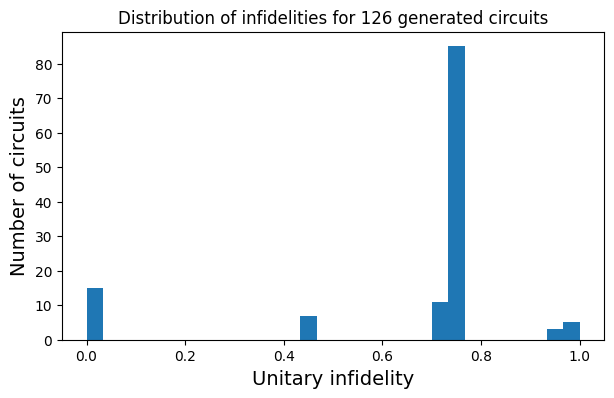

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
plt.title(
    f"Distribution of infidelities for {len(infidelities)} generated circuits",
    fontsize=12)
plt.ylabel("Number of circuits", fontsize=14)
plt.xlabel("Unitary infidelity", fontsize=14)
plt.hist(infidelities, bins=30)
plt.show()

As we see above, we now have around 15 kernels that compile the desired unitary! This is particularly valuable when dealing with hardware constraints, where, for instance, we might want to avoid using certain qubits or specific gates. One practical example is finding the circuit with the fewest CNOT gates (also known as `cx`). In our `cont_vocabulary` definition above, we identified that `cx` corresponds to the label 2 in our tokenized tensors. 

In [41]:
cx_token = cont_vocabulary["cx"]
cx_token

2

Let's use this information to search for the circuit that minimizes the number of `cx` gates:

In [42]:
# First, we remove possible duplicates and only pick distinct circuits
_, idx_unique = torch.unique(generated_tensors, dim=0, return_inverse=True)
unique_tensors = generated_tensors[idx_unique]
unique_infidelities = infidelities[idx_unique]
unique_kernels = [generated_kernels[idx] for idx in idx_unique]

# Then, find the correct circuits
idx_correct = torch.argwhere(unique_infidelities < 0.01).flatten()
correct_tensors = unique_tensors[idx_correct]
print(
    f"The model generated {correct_tensors.shape[0]} distinct circuits with infidelity < 0.01."
)

# Now let's flatten the last two dimensions (related to the actual circuit) and find out how many 2's (i.e. cx) gates each circuit has:
num_cx = (correct_tensors.flatten(1, 2) == cx_token).sum(1)
print("These circuits have this number of cx gates:", num_cx.tolist())

The model generated 14 distinct circuits with infidelity < 0.01.
These circuits have this number of cx gates: [0, 2, 1, 0, 2, 3, 2, 2, 1, 2, 2, 1, 1, 1]


As we can see, the diffusion model (DM) uses 0 to 3 CNOT gates to compile the unitary. We can now print a few of these circuits to select the one that best suits our needs, or to study whether there are any interesting patterns the model employs for this specific unitary.

For instance, we can sort the circuits by their `cx` count and plot them.

In [43]:
# Get the correct kernels
correct_kernels = [unique_kernels[idx] for idx in idx_correct]

# Order the gates by cx count
correct_kernels_cx_sorted = [
    (correct_kernels[idx], num_cx[idx]) for idx in torch.argsort(num_cx)
]

# Draw a few of these circuits
input_state = [0] * (2**num_of_qubits)
input_state[0] = 1

for correct_kernel, num_cx_gates in correct_kernels_cx_sorted[:3]:
    kernel = correct_kernel.kernel
    thetas = correct_kernel.params

    print(f"Generated circuit with {num_cx_gates} cx:")
    print(cudaq.draw(kernel, input_state, thetas))

Generated circuit with 0 cx:
     ╭───╮                     ╭───────────╮
q0 : ┤ x ├──────────────●──────┤ rz(3.132) ├
     ╰─┬─╯              │      ├───────────┤
q1 : ──●────────╳───────┼──────┤ rz(9.379) ├
       │  ╭───╮ │ ╭─────┴─────╮╰───────────╯
q2 : ──●──┤ h ├─╳─┤ r1(3.084) ├─────────────
          ╰───╯   ╰───────────╯             

Generated circuit with 0 cx:
     ╭───╮╭───────────╮╭───╮                
q0 : ┤ x ├┤ ry(1.563) ├┤ h ├──────●─────────
     ╰─┬─╯╰───────────╯╰───╯╭─────┴─────╮   
q1 : ──●────────────────────┤ r1(3.135) ├─╳─
       │   ╭────────╮       ╰───────────╯ │ 
q2 : ──●───┤ ry(11) ├─────────────────────╳─
           ╰────────╯                       

Generated circuit with 1 cx:
     ╭───╮    ╭───╮       ╭───╮╭───────────╮
q0 : ┤ x ├────┤ h ├───────┤ x ├┤ ry(4.687) ├
     ╰─┬─╯    ╰───╯       ╰─┬─╯╰───────────╯
q1 : ──●────────────────╳───┼───────────────
       │  ╭───────────╮ │   │               
q2 : ──●──┤ ry(4.727) ├─╳───●───────────────
          ╰

In [44]:
print(cudaq.__version__)
print("genQC Version", genQC.__version__)

CUDA-Q Version  (https://github.com/NVIDIA/cuda-quantum 61ab27724312c6eb197a7d543218925457f08d44)
genQC Version 0.2.3
